# Import Librerie

In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import random
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Definizione funzioni

In [4]:
def RMSE_Loss(actual, predicted):
    """Root Mean Squared Error"""
    return np.sqrt(np.mean(np.square(actual - predicted.flatten())))

In [5]:
def getRemoteDataset():
    return pd.read_csv('https://raw.githubusercontent.com/Uniba-dev-projects/forecasting-framework/master/synthetic_dataset/synthetic_dataset.csv')    

In [6]:
def extractDataframeAndSeries(key, dataset):
    df = dataset[[key]]
    df = df.rename(columns={key: "t"}).reset_index()
    df.series = df.t.str.replace(",",".", regex=True).astype(np.float32)
    return df, df.series.squeeze()

In [7]:
def calculateResiduals(y, y_predicted):
    loss = []
    for i in range(len(y)):
        loss.append(abs(y[i]-y_predicted[i]))
    return loss

# Inizializzazione e Visualizzazione Serie Temporali Sintentiche

In [8]:
dataset = getRemoteDataset()
_, series1 = extractDataframeAndSeries('y1(t) = t/1000 = y1(t-1)+0.001', dataset)
_, series2 = extractDataframeAndSeries('y2(t)=y2(t-1)*0.999', dataset)
_, series3 = extractDataframeAndSeries('y3(t)=y1(t)+y2(t)', dataset)
_, series4 = extractDataframeAndSeries('y4(t) = y4(t-1)-0.001', dataset)
_, series5 = extractDataframeAndSeries('y5(t)=y1(t)*t%2+y4(t)*(1-t%2)', dataset)

<AxesSubplot:xlabel='x', ylabel='y'>

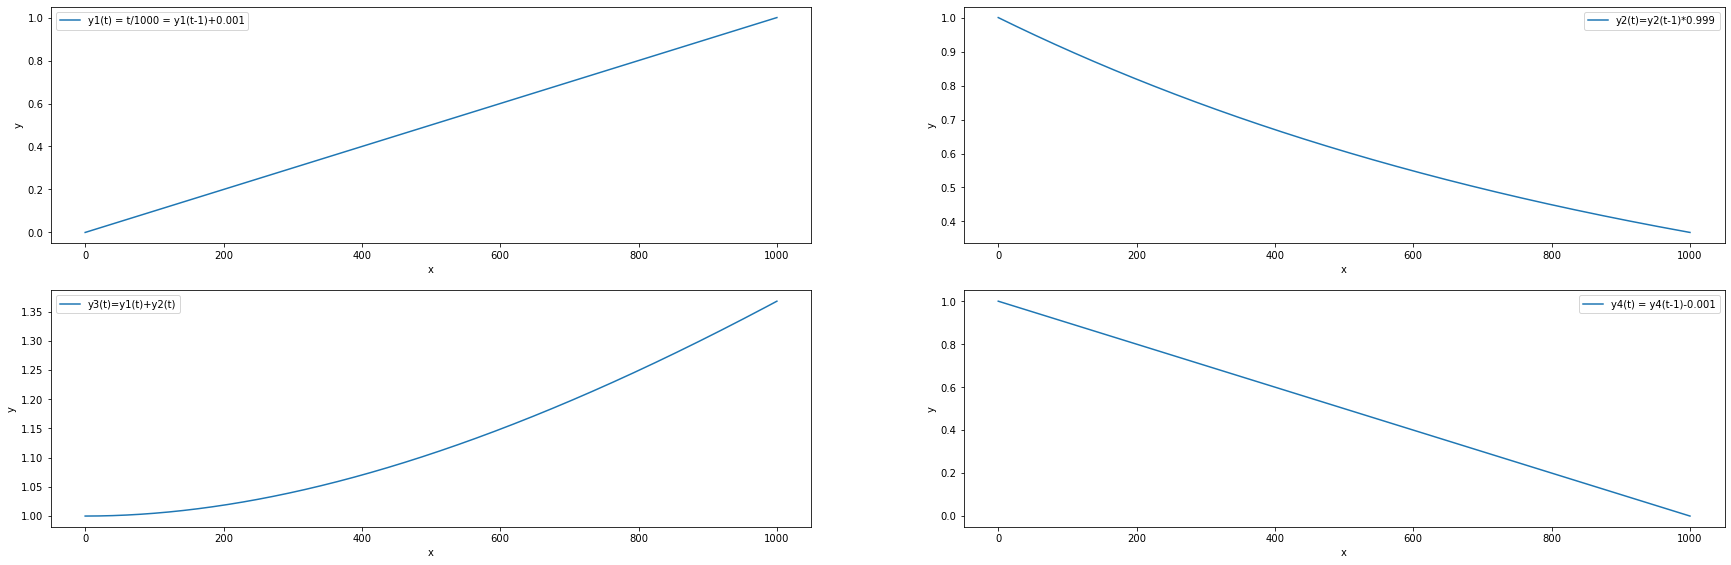

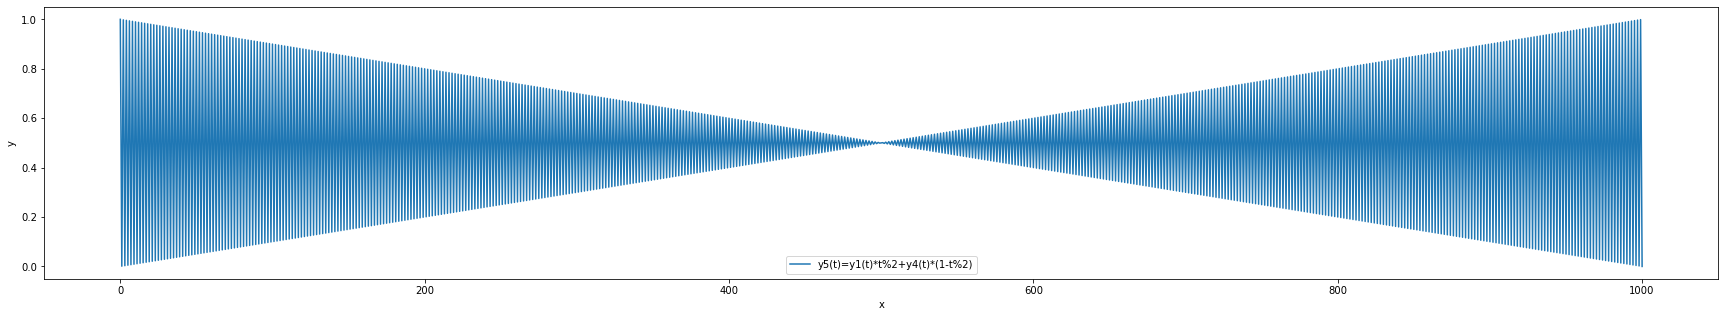

In [25]:
plt.figure(figsize=(30,20))

plt.subplot(4, 2, 1)
series1.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y1(t) = t/1000 = y1(t-1)+0.001")

plt.subplot(4, 2, 2)
series2.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y2(t)=y2(t-1)*0.999")

plt.subplot(4, 2, 3)
series3.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y3(t)=y1(t)+y2(t)")

plt.subplot(4, 2, 4)
series4.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y4(t) = y4(t-1)-0.001")

plt.figure(figsize=(30,5))
series5.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y5(t)=y1(t)*t%2+y4(t)*(1-t%2)")

# DatasetManager e Inizializzazione SVR
DatasetManager restituisce da una serie temporale un pandas.DataFrame definendo il nuemro di feature e il numero di variabili target.

In [19]:
class DatasetManager():
    def __getPandasFromNumpySeries(self, series, features_sequences=1, target_sequences=1, offset=0):

        dfTemp = pd.DataFrame({"ref": series})
        for i in range(target_sequences):
            dfTemp['t+'+str(target_sequences-i)] = dfTemp.ref.shift(i)

        dfTemp['t'] = dfTemp.ref.shift(target_sequences)

        for j in range(features_sequences-1):
            dfTemp['t-'+str(j+1)] = dfTemp.ref.shift(target_sequences+j+1)

        dfTemp.drop(columns=["ref"], inplace=True)
        dropLine = features_sequences+target_sequences-1

        if(offset > 0):
            dfTemp['t'] = dfTemp['t'].shift(offset)
            for i in range(features_sequences-1):
                dfTemp['t-'+str(i+1)] = dfTemp['t-'+str(i+1)].shift(offset)
        
        dfTemp.drop(np.arange(0, dropLine+offset), inplace=True)
    
        return dfTemp[dfTemp.columns[::-1]].reset_index().drop(columns=["index"])

    def __init__(self, sequences, features_sequences=1, target_sequences=1, offset=0, portion=0.8):
        self.sequences = sequences
        self.features_sequences = features_sequences
        self.target_sequences = target_sequences
        self.offset = offset
        self.portion = portion
        self.df = self.__getPandasFromNumpySeries(sequences, features_sequences, target_sequences, offset)

    def __len__(self):
        return len(self.sequences)

    def __get_columns(self):
        return self.df[self.df.columns[0:self.features_sequences]].to_numpy().astype(np.float32), self.df[self.df.columns[self.features_sequences:]].to_numpy().astype(np.float32)

    def __train_and_test_set__(self, random_state):
        xCol, yCol = self.__get_columns()
        return train_test_split(xCol, yCol, train_size=self.portion, random_state=random_state)  

    def __get_ordered_series__(self):
        return self.__get_columns()

In [20]:
def svr_model_5(X, y, kernel, verbose=False):

    # Ricerca dei parametri ottimali (C e gamma)
    # usando GridSearch con 5-fold Cross Validation
    gsc = GridSearchCV(
        estimator=SVR(kernel=kernel),
        param_grid={
            'C': [0.05, 0.1, 1, 2, 4, 8, 10],
            'gamma': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5]
        },
        cv=5,
        n_jobs=-1,
        scoring=make_scorer(RMSE_Loss, greater_is_better=False),
        return_train_score=True
    )
    
    grid_result = gsc.fit(X, y.flatten())
    best_params = grid_result.best_params_
    best_score = grid_result.best_score_
    if verbose is True:
        print("Parametri ottimali:", best_params)
        print("Miglior score:", best_score)

    # Applicazione del modello SVR applicando i parametri ottimali
    best_svr = SVR(kernel=kernel, C=best_params['C'], gamma=best_params['gamma'])
    best_svr.fit(X, y.flatten())
    predicted_sales_train = best_svr.predict(X)

    if verbose is True:
        for d, i, j in zip(X, y, predicted_sales_train):
            print(d,i,j)

    train_rmse = RMSE_Loss(y.flatten(), predicted_sales_train)
    
    return best_svr, train_rmse, predicted_sales_train

In [21]:
def TestingSVR(X, y, best_svr, verbose=False):
    predicted_sales_test = best_svr.predict(X)
    if verbose is True:
        for d, i, j in zip(X, y, predicted_sales_test):
            print(d,i,j)
    test_rmsse = RMSE_Loss(y.flatten(), predicted_sales_test)
    return predicted_sales_test, test_rmsse

In [22]:
def showResultGraph(label, error_train, error_test, residual_train, residual_test, y_train, yhat_train, y_test, yhat_test, ordered_y, ordered_yhat, fileName):
    plt.figure(figsize=(15,3))
    plt.title(label)
    plt.plot(ordered_y)
    plt.plot(ordered_yhat)
    plt.legend(["True", "Predicted"])
    plt.savefig(str(fileName+"-1"))

    plt.figure(figsize=(40,5))
    plt.subplot(1, 4, 1)
    plt.title("Train Set")
    plt.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="Train")
    plt.plot(y_train)
    plt.plot(yhat_train)
    plt.xlabel("RMSE: "+str(np.float32(error_train)))
    plt.legend(["True", "Predicted"])

    plt.subplot(1, 4, 2)
    plt.title("Test Set")
    plt.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="Test")
    plt.plot(y_test)
    plt.plot(yhat_test)
    plt.xlabel("RMSE: "+str(np.float32(error_test)))
    plt.legend(["True", "Predicted"])

    plt.subplot(1, 4, 3)
    plt.title("Residuals Train Set")
    plt.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="Residuals Train")
    plt.plot(residual_train)
    plt.legend(["Residuals"])

    plt.subplot(1, 4, 4)
    plt.title("Residuals Test Set")
    plt.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="Residuals Test")
    plt.plot(residual_test)
    plt.legend(["Residuals"])
    plt.savefig(str(fileName+"-2"))

In [23]:
def executeSVR(label, series, feature_sequences=1, target_sequences=1, portion=0.8, offset=0, show=False, kernel="rbf", fileName=""):
    data = DatasetManager(
        series,
        features_sequences=feature_sequences,
        target_sequences=target_sequences,
        portion=portion,
        offset=offset
    )
    X_train, X_test, y_train, y_test = data.__train_and_test_set__(random_state=1)

    best_svr, train_rmse, y_predicted_in_train = svr_model_5(X_train, y_train, kernel)
    y_predicted_in_test, test_rmse = TestingSVR(X_test, y_test, best_svr)

    #TO SHOW
    x_show, y_show = data.__get_ordered_series__()
    yhat_show, rmse_show = TestingSVR(x_show, y_show, best_svr)

    residualsTrain = calculateResiduals(y_train.flatten(), y_predicted_in_train)
    residualsTest = calculateResiduals(y_test.flatten(), y_predicted_in_test)
    if(show):
        showResultGraph(
            label = label,
            error_train = train_rmse,
            error_test = test_rmse,
            residual_train = residualsTrain,
            residual_test = residualsTest,
            y_train = y_train.flatten(),
            yhat_train = y_predicted_in_train,
            y_test = y_test.flatten(),
            yhat_test = y_predicted_in_test,
            ordered_y = y_show,
            ordered_yhat = yhat_show,
            fileName=fileName
        )
    return train_rmse, test_rmse, np.mean(residualsTrain), np.mean(residualsTest)

In [24]:
def printTableResult(
    kernel,
    trrm1=None, term1=None, trre1=None, tere1=None,
    trrm2=None, term2=None, trre2=None, tere2=None,
    trrm3=None, term3=None, trre3=None, tere3=None,
    trrm4=None, term4=None, trre4=None, tere4=None,
    trrm5=None, term5=None, trre5=None, tere5=None,
    trrmo1=None, termo1=None, trreo1=None, tereo1=None,
    trrmo2=None, termo2=None, trreo2=None, tereo2=None,
    trrmo3=None, termo3=None, trreo3=None, tereo3=None,
    trrmo4=None, termo4=None, trreo4=None, tereo4=None,
    trrmo5=None, termo5=None, trreo5=None, tereo5=None,
    trrmfo1=None, termfo1=None, trrefo1=None, terefo1=None,
    trrmfo2=None, termfo2=None, trrefo2=None, terefo2=None,
    trrmfo3=None, termfo3=None, trrefo3=None, terefo3=None,
    trrmfo4=None, termfo4=None, trrefo4=None, terefo4=None,
    trrmfo5=None, termfo5=None, trrefo5=None, terefo5=None
):
    print("\t\tKERNEL\t\tFEATUES\t\tOFFSET\t\tRMSE TRAIN\tRMSE TEST\tRESIDUALS TRAIN\tRESIDUALS TEST")
    print("\t\t"+kernel+"\t\t1\t\t0\t\t{0:.4f}".format(trrm1)+"\t\t{0:.4f}".format(term1)+"\t\t{0:.4f}".format(trre1)+"\t\t{0:.4f}".format(tere1))
    print("\t\t"+kernel+"\t\t2\t\t0\t\t{0:.4f}".format(trrm2)+"\t\t{0:.4f}".format(term2)+"\t\t{0:.4f}".format(trre2)+"\t\t{0:.4f}".format(tere2))
    print("\t\t"+kernel+"\t\t3\t\t0\t\t{0:.4f}".format(trrm3)+"\t\t{0:.4f}".format(term3)+"\t\t{0:.4f}".format(trre3)+"\t\t{0:.4f}".format(tere3))
    print("\t\t"+kernel+"\t\t4\t\t0\t\t{0:.4f}".format(trrm4)+"\t\t{0:.4f}".format(term4)+"\t\t{0:.4f}".format(trre4)+"\t\t{0:.4f}".format(tere4))
    print("\t\t"+kernel+"\t\t5\t\t0\t\t{0:.4f}".format(trrm5)+"\t\t{0:.4f}".format(term5)+"\t\t{0:.4f}".format(trre5)+"\t\t{0:.4f}".format(tere5))
    print("\t\t"+kernel+"\t\t1\t\t1\t\t{0:.4f}".format(trrmo1)+"\t\t{0:.4f}".format(termo1)+"\t\t{0:.4f}".format(trreo1)+"\t\t{0:.4f}".format(tereo1))
    print("\t\t"+kernel+"\t\t1\t\t2\t\t{0:.4f}".format(trrmo2)+"\t\t{0:.4f}".format(termo2)+"\t\t{0:.4f}".format(trreo2)+"\t\t{0:.4f}".format(tereo2))
    print("\t\t"+kernel+"\t\t1\t\t3\t\t{0:.4f}".format(trrmo3)+"\t\t{0:.4f}".format(termo3)+"\t\t{0:.4f}".format(trreo3)+"\t\t{0:.4f}".format(tereo3))
    print("\t\t"+kernel+"\t\t1\t\t4\t\t{0:.4f}".format(trrmo4)+"\t\t{0:.4f}".format(termo4)+"\t\t{0:.4f}".format(trreo4)+"\t\t{0:.4f}".format(tereo4))
    print("\t\t"+kernel+"\t\t1\t\t5\t\t{0:.4f}".format(trrmo5)+"\t\t{0:.4f}".format(termo5)+"\t\t{0:.4f}".format(trreo5)+"\t\t{0:.4f}".format(tereo5))
    print("\t\t"+kernel+"\t\t1\t\t1\t\t{0:.4f}".format(trrmfo1)+"\t\t{0:.4f}".format(termfo1)+"\t\t{0:.4f}".format(trrefo1)+"\t\t{0:.4f}".format(terefo1))
    print("\t\t"+kernel+"\t\t2\t\t2\t\t{0:.4f}".format(trrmfo2)+"\t\t{0:.4f}".format(termfo2)+"\t\t{0:.4f}".format(trrefo2)+"\t\t{0:.4f}".format(terefo2))
    print("\t\t"+kernel+"\t\t3\t\t3\t\t{0:.4f}".format(trrmfo3)+"\t\t{0:.4f}".format(termfo3)+"\t\t{0:.4f}".format(trrefo3)+"\t\t{0:.4f}".format(terefo3))
    print("\t\t"+kernel+"\t\t4\t\t4\t\t{0:.4f}".format(trrmfo4)+"\t\t{0:.4f}".format(termfo4)+"\t\t{0:.4f}".format(trrefo4)+"\t\t{0:.4f}".format(terefo4))
    print("\t\t"+kernel+"\t\t5\t\t5\t\t{0:.4f}".format(trrmfo5)+"\t\t{0:.4f}".format(termfo5)+"\t\t{0:.4f}".format(trrefo5)+"\t\t{0:.4f}".format(terefo5))

# Esecuzione SVR

## SVR RBF 1

In [17]:
trrm1, term1, trre1, tere1 = executeSVR("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=1, target_sequences=1, portion=0.8, fileName="SVR1_1", show=True)
trrm2, term2, trre2, tere2 = executeSVR("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=2, target_sequences=1, portion=0.8, fileName="SVR1_2", show=True)
trrm3, term3, trre3, tere3 = executeSVR("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=3, target_sequences=1, portion=0.8, fileName="SVR1_3", show=True)
trrm4, term4, trre4, tere4 = executeSVR("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=4, target_sequences=1, portion=0.8, fileName="SVR1_4", show=True)
trrm5, term5, trre5, tere5 = executeSVR("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=5, target_sequences=1, portion=0.8, fileName="SVR1_5", show=True)
trrmo1, termo1, trreo1, tereo1 = executeSVR("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=1, offset=1, portion=0.8, fileName="SVR1_6", show=True)
trrmo2, termo2, trreo2, tereo2 = executeSVR("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=1, offset=2, portion=0.8, fileName="SVR1_7", show=True)
trrmo3, termo3, trreo3, tereo3 = executeSVR("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=1, offset=3, portion=0.8, fileName="SVR1_8", show=True)
trrmo4, termo4, trreo4, tereo4 = executeSVR("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=1, offset=4, portion=0.8, fileName="SVR1_9", show=True)
trrmo5, termo5, trreo5, tereo5 = executeSVR("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=1, offset=5, portion=0.8, fileName="SVR1_10", show=True)
trrmm1, termm1, trremm1, terem1 = executeSVR("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=1, offset=1, portion=0.8, fileName="SVR1_11", show=True)
trrmm2, termm2, trremm2, terem2 = executeSVR("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=2, offset=2, portion=0.8, fileName="SVR1_12", show=True)
trrmm3, termm3, trremm3, terem3 = executeSVR("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=3, offset=3, portion=0.8, fileName="SVR1_13", show=True)
trrmm4, termm4, trremm4, terem4 = executeSVR("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=4, offset=4, portion=0.8, fileName="SVR1_14", show=True)
trrmm5, termm5, trremm5, terem5 = executeSVR("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=5, offset=5, portion=0.8, fileName="SVR1_15", show=True)

KeyboardInterrupt: 

In [ ]:
printTableResult("rbf",
trrm1, term1, trre1, tere1,
trrm2, term2, trre2, tere2,
trrm3, term3, trre3, tere3,
trrm4, term4, trre4, tere4,
trrm5, term5, trre5, tere5,
trrmo1, termo1, trreo1, tereo1,
trrmo2, termo2, trreo2, tereo2,
trrmo3, termo3, trreo3, tereo3,
trrmo4, termo4, trreo4, tereo4,
trrmo5, termo5, trreo5, tereo5,
trrmm1, termm1, trremm1, terem1,
trrmm2, termm2, trremm2, terem2,
trrmm3, termm3, trremm3, terem3,
trrmm4, termm4, trremm4, terem4,
trrmm5, termm5, trremm5, terem5
)

## SVR LIN 1

In [ ]:
trrm1, term1, trre1, tere1 = executeSVR("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=1, target_sequences=1, portion=0.8, kernel="linear", show=True, fileName="SVR1_16")
trrm2, term2, trre2, tere2 = executeSVR("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=2, target_sequences=1, portion=0.8, kernel="linear", show=True, fileName="SVR1_17")
trrm3, term3, trre3, tere3 = executeSVR("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=3, target_sequences=1, portion=0.8, kernel="linear", show=True, fileName="SVR1_18")
trrm4, term4, trre4, tere4 = executeSVR("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=4, target_sequences=1, portion=0.8, kernel="linear", show=True, fileName="SVR1_19")
trrm5, term5, trre5, tere5 = executeSVR("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=5, target_sequences=1, portion=0.8, kernel="linear", show=True, fileName="SVR1_20")
trrmo1, termo1, trreo1, tereo1 = executeSVR("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=1, offset=1, portion=0.8, kernel="linear", show=True, fileName="SVR1_21")
trrmo2, termo2, trreo2, tereo2 = executeSVR("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=1, offset=2, portion=0.8, kernel="linear", show=True, fileName="SVR1_22")
trrmo3, termo3, trreo3, tereo3 = executeSVR("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=1, offset=3, portion=0.8, kernel="linear", show=True, fileName="SVR1_23")
trrmo4, termo4, trreo4, tereo4 = executeSVR("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=1, offset=4, portion=0.8, kernel="linear", show=True, fileName="SVR1_24")
trrmo5, termo5, trreo5, tereo5 = executeSVR("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=1, offset=5, portion=0.8, kernel="linear", show=True, fileName="SVR1_25")
trrmm1, termm1, trremm1, terem1 = executeSVR("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=1, offset=1, portion=0.8, kernel="linear", show=True, fileName="SVR1_26")
trrmm2, termm2, trremm2, terem2 = executeSVR("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=2, offset=2, portion=0.8, kernel="linear", show=True, fileName="SVR1_27")
trrmm3, termm3, trremm3, terem3 = executeSVR("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=3, offset=3, portion=0.8, kernel="linear", show=True, fileName="SVR1_28")
trrmm4, termm4, trremm4, terem4 = executeSVR("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=4, offset=4, portion=0.8, kernel="linear", show=True, fileName="SVR1_29")
trrmm5, termm5, trremm5, terem5 = executeSVR("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=5, offset=5, portion=0.8, kernel="linear", show=True, fileName="SVR1_30")

In [ ]:
printTableResult("linear",
trrm1, term1, trre1, tere1,
trrm2, term2, trre2, tere2,
trrm3, term3, trre3, tere3,
trrm4, term4, trre4, tere4,
trrm5, term5, trre5, tere5,
trrmo1, termo1, trreo1, tereo1,
trrmo2, termo2, trreo2, tereo2,
trrmo3, termo3, trreo3, tereo3,
trrmo4, termo4, trreo4, tereo4,
trrmo5, termo5, trreo5, tereo5,
trrmm1, termm1, trremm1, terem1,
trrmm2, termm2, trremm2, terem2,
trrmm3, termm3, trremm3, terem3,
trrmm4, termm4, trremm4, terem4,
trrmm5, termm5, trremm5, terem5
)

		KERNEL		FEATUES		OFFSET		RMSE TRAIN	RMSE TEST	RESIDUALS TRAIN	RESIDUALS TEST
		linear		1		0		0.0579		0.0574		0.0503		0.0489
		linear		2		0		0.0578		0.0576		0.0503		0.0492
		linear		3		0		0.0577		0.0581		0.0500		0.0502
		linear		4		0		0.0577		0.0581		0.0500		0.0501
		linear		5		0		0.0577		0.0583		0.0500		0.0503
		linear		1		1		0.0578		0.0576		0.0503		0.0492
		linear		1		2		0.0577		0.0581		0.0500		0.0502
		linear		1		3		0.0577		0.0581		0.0500		0.0501
		linear		1		4		0.0577		0.0583		0.0500		0.0503
		linear		1		5		0.0575		0.0589		0.0499		0.0508
		linear		1		1		0.0578		0.0576		0.0503		0.0492
		linear		2		2		0.0577		0.0581		0.0500		0.0501
		linear		3		3		0.0575		0.0589		0.0499		0.0508
		linear		4		4		0.0569		0.0612		0.0491		0.0540
		linear		5		5		0.0578		0.0578		0.0499		0.0506


## SVR RBF 2

In [ ]:
trrm1, term1, trre1, tere1 = executeSVR("y2(t)=y2(t-1)*0.999", series2, feature_sequences=1, target_sequences=1, portion=0.8, fileName="SVR2_1", show=True)
trrm2, term2, trre2, tere2 = executeSVR("y2(t)=y2(t-1)*0.999", series2, feature_sequences=2, target_sequences=1, portion=0.8, fileName="SVR2_2", show=True)
trrm3, term3, trre3, tere3 = executeSVR("y2(t)=y2(t-1)*0.999", series2, feature_sequences=3, target_sequences=1, portion=0.8, fileName="SVR2_3", show=True)
trrm4, term4, trre4, tere4 = executeSVR("y2(t)=y2(t-1)*0.999", series2, feature_sequences=4, target_sequences=1, portion=0.8, fileName="SVR2_4", show=True)
trrm5, term5, trre5, tere5 = executeSVR("y2(t)=y2(t-1)*0.999", series2, feature_sequences=5, target_sequences=1, portion=0.8, fileName="SVR2_5", show=True)
trrmo1, termo1, trreo1, tereo1 = executeSVR("y2(t)=y2(t-1)*0.999", series2, feature_sequences=1, offset=1, portion=0.8, fileName="SVR2_6", show=True)
trrmo2, termo2, trreo2, tereo2 = executeSVR("y2(t)=y2(t-1)*0.999", series2, feature_sequences=1, offset=2, portion=0.8, fileName="SVR2_7", show=True)
trrmo3, termo3, trreo3, tereo3 = executeSVR("y2(t)=y2(t-1)*0.999", series2, feature_sequences=1, offset=3, portion=0.8, fileName="SVR2_8", show=True)
trrmo4, termo4, trreo4, tereo4 = executeSVR("y2(t)=y2(t-1)*0.999", series2, feature_sequences=1, offset=4, portion=0.8, fileName="SVR2_9", show=True)
trrmo5, termo5, trreo5, tereo5 = executeSVR("y2(t)=y2(t-1)*0.999", series2, feature_sequences=1, offset=5, portion=0.8, fileName="SVR2_10", show=True)
trrmm1, termm1, trremm1, terem1 = executeSVR("y2(t)=y2(t-1)*0.999", series2, feature_sequences=1, offset=1, portion=0.8, fileName="SVR2_11", show=True)
trrmm2, termm2, trremm2, terem2 = executeSVR("y2(t)=y2(t-1)*0.999", series2, feature_sequences=2, offset=2, portion=0.8, fileName="SVR2_12", show=True)
trrmm3, termm3, trremm3, terem3 = executeSVR("y2(t)=y2(t-1)*0.999", series2, feature_sequences=3, offset=3, portion=0.8, fileName="SVR2_13", show=True)
trrmm4, termm4, trremm4, terem4 = executeSVR("y2(t)=y2(t-1)*0.999", series2, feature_sequences=4, offset=4, portion=0.8, fileName="SVR2_14", show=True)
trrmm5, termm5, trremm5, terem5 = executeSVR("y2(t)=y2(t-1)*0.999", series2, feature_sequences=5, offset=5, portion=0.8, fileName="SVR2_15", show=True)

In [ ]:
printTableResult("rbf",
trrm1, term1, trre1, tere1,
trrm2, term2, trre2, tere2,
trrm3, term3, trre3, tere3,
trrm4, term4, trre4, tere4,
trrm5, term5, trre5, tere5,
trrmo1, termo1, trreo1, tereo1,
trrmo2, termo2, trreo2, tereo2,
trrmo3, termo3, trreo3, tereo3,
trrmo4, termo4, trreo4, tereo4,
trrmo5, termo5, trreo5, tereo5,
trrmm1, termm1, trremm1, terem1,
trrmm2, termm2, trremm2, terem2,
trrmm3, termm3, trremm3, terem3,
trrmm4, termm4, trremm4, terem4,
trrmm5, termm5, trremm5, terem5
)

## SVR LIN 2

In [ ]:
trrm1, term1, trre1, tere1 = executeSVR("y2(t)=y2(t-1)*0.999", series2, feature_sequences=1, target_sequences=1, portion=0.8, kernel="linear", show=True, fileName="SVR2_16")
trrm2, term2, trre2, tere2 = executeSVR("y2(t)=y2(t-1)*0.999", series2, feature_sequences=2, target_sequences=1, portion=0.8, kernel="linear", show=True, fileName="SVR2_17")
trrm3, term3, trre3, tere3 = executeSVR("y2(t)=y2(t-1)*0.999", series2, feature_sequences=3, target_sequences=1, portion=0.8, kernel="linear", show=True, fileName="SVR2_18")
trrm4, term4, trre4, tere4 = executeSVR("y2(t)=y2(t-1)*0.999", series2, feature_sequences=4, target_sequences=1, portion=0.8, kernel="linear", show=True, fileName="SVR2_19")
trrm5, term5, trre5, tere5 = executeSVR("y2(t)=y2(t-1)*0.999", series2, feature_sequences=5, target_sequences=1, portion=0.8, kernel="linear", show=True, fileName="SVR2_20")
trrmo1, termo1, trreo1, tereo1 = executeSVR("y2(t)=y2(t-1)*0.999", series2, feature_sequences=1, offset=1, portion=0.8, kernel="linear", show=True, fileName="SVR2_21")
trrmo2, termo2, trreo2, tereo2 = executeSVR("y2(t)=y2(t-1)*0.999", series2, feature_sequences=1, offset=2, portion=0.8, kernel="linear", show=True, fileName="SVR2_22")
trrmo3, termo3, trreo3, tereo3 = executeSVR("y2(t)=y2(t-1)*0.999", series2, feature_sequences=1, offset=3, portion=0.8, kernel="linear", show=True, fileName="SVR2_23")
trrmo4, termo4, trreo4, tereo4 = executeSVR("y2(t)=y2(t-1)*0.999", series2, feature_sequences=1, offset=4, portion=0.8, kernel="linear", show=True, fileName="SVR2_24")
trrmo5, termo5, trreo5, tereo5 = executeSVR("y2(t)=y2(t-1)*0.999", series2, feature_sequences=1, offset=5, portion=0.8, kernel="linear", show=True, fileName="SVR2_25")
trrmm1, termm1, trremm1, terem1 = executeSVR("y2(t)=y2(t-1)*0.999", series2, feature_sequences=1, offset=1, portion=0.8, kernel="linear", show=True, fileName="SVR2_26")
trrmm2, termm2, trremm2, terem2 = executeSVR("y2(t)=y2(t-1)*0.999", series2, feature_sequences=2, offset=2, portion=0.8, kernel="linear", show=True, fileName="SVR2_27")
trrmm3, termm3, trremm3, terem3 = executeSVR("y2(t)=y2(t-1)*0.999", series2, feature_sequences=3, offset=3, portion=0.8, kernel="linear", show=True, fileName="SVR2_28")
trrmm4, termm4, trremm4, terem4 = executeSVR("y2(t)=y2(t-1)*0.999", series2, feature_sequences=4, offset=4, portion=0.8, kernel="linear", show=True, fileName="SVR2_29")
trrmm5, termm5, trremm5, terem5 = executeSVR("y2(t)=y2(t-1)*0.999", series2, feature_sequences=5, offset=5, portion=0.8, kernel="linear", show=True, fileName="SVR2_30")

In [ ]:
printTableResult("rbf",
trrm1, term1, trre1, tere1,
trrm2, term2, trre2, tere2,
trrm3, term3, trre3, tere3,
trrm4, term4, trre4, tere4,
trrm5, term5, trre5, tere5,
trrmo1, termo1, trreo1, tereo1,
trrmo2, termo2, trreo2, tereo2,
trrmo3, termo3, trreo3, tereo3,
trrmo4, termo4, trreo4, tereo4,
trrmo5, termo5, trreo5, tereo5,
trrmm1, termm1, trremm1, terem1,
trrmm2, termm2, trremm2, terem2,
trrmm3, termm3, trremm3, terem3,
trrmm4, termm4, trremm4, terem4,
trrmm5, termm5, trremm5, terem5
)

## SVR RBF 3

In [ ]:
trrm1, term1, trre1, tere1 = executeSVR("y3(t)=y1(t)+y2(t)", series3, feature_sequences=1, target_sequences=1, portion=0.8, show=True, fileName="SVR3_1")
trrm2, term2, trre2, tere2 = executeSVR("y3(t)=y1(t)+y2(t)", series3, feature_sequences=2, target_sequences=1, portion=0.8, show=True, fileName="SVR3_2")
trrm3, term3, trre3, tere3 = executeSVR("y3(t)=y1(t)+y2(t)", series3, feature_sequences=3, target_sequences=1, portion=0.8, show=True, fileName="SVR3_3")
trrm4, term4, trre4, tere4 = executeSVR("y3(t)=y1(t)+y2(t)", series3, feature_sequences=4, target_sequences=1, portion=0.8, show=True, fileName="SVR3_4")
trrm5, term5, trre5, tere5 = executeSVR("y3(t)=y1(t)+y2(t)", series3, feature_sequences=5, target_sequences=1, portion=0.8, show=True, fileName="SVR3_5")
trrmo1, termo1, trreo1, tereo1 = executeSVR("y3(t)=y1(t)+y2(t)", series3, feature_sequences=1, offset=1, portion=0.8, show=True, fileName="SVR3_6")
trrmo2, termo2, trreo2, tereo2 = executeSVR("y3(t)=y1(t)+y2(t)", series3, feature_sequences=1, offset=2, portion=0.8, show=True, fileName="SVR3_7")
trrmo3, termo3, trreo3, tereo3 = executeSVR("y3(t)=y1(t)+y2(t)", series3, feature_sequences=1, offset=3, portion=0.8, show=True, fileName="SVR3_8")
trrmo4, termo4, trreo4, tereo4 = executeSVR("y3(t)=y1(t)+y2(t)", series3, feature_sequences=1, offset=4, portion=0.8, show=True, fileName="SVR3_9")
trrmo5, termo5, trreo5, tereo5 = executeSVR("y3(t)=y1(t)+y2(t)", series3, feature_sequences=1, offset=5, portion=0.8, show=True, fileName="SVR3_10")
trrmm1, termm1, trremm1, terem1 = executeSVR("y3(t)=y1(t)+y2(t)", series3, feature_sequences=1, offset=1, portion=0.8, show=True, fileName="SVR3_11")
trrmm2, termm2, trremm2, terem2 = executeSVR("y3(t)=y1(t)+y2(t)", series3, feature_sequences=2, offset=2, portion=0.8, show=True, fileName="SVR3_12")
trrmm3, termm3, trremm3, terem3 = executeSVR("y3(t)=y1(t)+y2(t)", series3, feature_sequences=3, offset=3, portion=0.8, show=True, fileName="SVR3_13")
trrmm4, termm4, trremm4, terem4 = executeSVR("y3(t)=y1(t)+y2(t)", series3, feature_sequences=4, offset=4, portion=0.8, show=True, fileName="SVR3_14")
trrmm5, termm5, trremm5, terem5 = executeSVR("y3(t)=y1(t)+y2(t)", series3, feature_sequences=5, offset=5, portion=0.8, show=True, fileName="SVR3_15")

In [ ]:
printTableResult("rbf",
trrm1, term1, trre1, tere1,
trrm2, term2, trre2, tere2,
trrm3, term3, trre3, tere3,
trrm4, term4, trre4, tere4,
trrm5, term5, trre5, tere5,
trrmo1, termo1, trreo1, tereo1,
trrmo2, termo2, trreo2, tereo2,
trrmo3, termo3, trreo3, tereo3,
trrmo4, termo4, trreo4, tereo4,
trrmo5, termo5, trreo5, tereo5,
trrmm1, termm1, trremm1, terem1,
trrmm2, termm2, trremm2, terem2,
trrmm3, termm3, trremm3, terem3,
trrmm4, termm4, trremm4, terem4,
trrmm5, termm5, trremm5, terem5
)

		KERNEL		FEATUES		OFFSET		RMSE TRAIN	RMSE TEST	RESIDUALS TRAIN	RESIDUALS TEST
		rbf		1		0		0.0646		0.0639		0.0567		0.0551
		rbf		2		0		0.0626		0.0620		0.0541		0.0531
		rbf		3		0		0.0611		0.0606		0.0523		0.0509
		rbf		4		0		0.0602		0.0596		0.0511		0.0496
		rbf		5		0		0.0595		0.0594		0.0503		0.0492
		rbf		1		1		0.0645		0.0639		0.0566		0.0554
		rbf		1		2		0.0644		0.0637		0.0566		0.0550
		rbf		1		3		0.0644		0.0635		0.0565		0.0548
		rbf		1		4		0.0643		0.0637		0.0564		0.0550
		rbf		1		5		0.0641		0.0640		0.0562		0.0556
		rbf		1		1		0.0645		0.0639		0.0566		0.0554
		rbf		2		2		0.0625		0.0617		0.0541		0.0525
		rbf		3		3		0.0608		0.0609		0.0520		0.0515
		rbf		4		4		0.0596		0.0608		0.0503		0.0517
		rbf		5		5		0.0595		0.0579		0.0503		0.0476


## SVR LIN 3

In [ ]:
trrm1, term1, trre1, tere1 = executeSVR("y3(t)=y1(t)+y2(t)", series3, feature_sequences=1, target_sequences=1, portion=0.8, kernel="linear", show=True, fileName="SVR3_16")
trrm2, term2, trre2, tere2 = executeSVR("y3(t)=y1(t)+y2(t)", series3, feature_sequences=2, target_sequences=1, portion=0.8, kernel="linear", show=True, fileName="SVR3_17")
trrm3, term3, trre3, tere3 = executeSVR("y3(t)=y1(t)+y2(t)", series3, feature_sequences=3, target_sequences=1, portion=0.8, kernel="linear", show=True, fileName="SVR3_18")
trrm4, term4, trre4, tere4 = executeSVR("y3(t)=y1(t)+y2(t)", series3, feature_sequences=4, target_sequences=1, portion=0.8, kernel="linear", show=True, fileName="SVR3_19")
trrm5, term5, trre5, tere5 = executeSVR("y3(t)=y1(t)+y2(t)", series3, feature_sequences=5, target_sequences=1, portion=0.8, kernel="linear", show=True, fileName="SVR3_20")
trrmo1, termo1, trreo1, tereo1 = executeSVR("y3(t)=y1(t)+y2(t)", series3, feature_sequences=1, offset=1, portion=0.8, kernel="linear", show=True, fileName="SVR3_21")
trrmo2, termo2, trreo2, tereo2 = executeSVR("y3(t)=y1(t)+y2(t)", series3, feature_sequences=1, offset=2, portion=0.8, kernel="linear", show=True, fileName="SVR3_22")
trrmo3, termo3, trreo3, tereo3 = executeSVR("y3(t)=y1(t)+y2(t)", series3, feature_sequences=1, offset=3, portion=0.8, kernel="linear", show=True, fileName="SVR3_23")
trrmo4, termo4, trreo4, tereo4 = executeSVR("y3(t)=y1(t)+y2(t)", series3, feature_sequences=1, offset=4, portion=0.8, kernel="linear", show=True, fileName="SVR3_24")
trrmo5, termo5, trreo5, tereo5 = executeSVR("y3(t)=y1(t)+y2(t)", series3, feature_sequences=1, offset=5, portion=0.8, kernel="linear", show=True, fileName="SVR3_25")
trrmm1, termm1, trremm1, terem1 = executeSVR("y3(t)=y1(t)+y2(t)", series3, feature_sequences=1, offset=1, portion=0.8, kernel="linear", show=True, fileName="SVR3_26")
trrmm2, termm2, trremm2, terem2 = executeSVR("y3(t)=y1(t)+y2(t)", series3, feature_sequences=2, offset=2, portion=0.8, kernel="linear", show=True, fileName="SVR3_27")
trrmm3, termm3, trremm3, terem3 = executeSVR("y3(t)=y1(t)+y2(t)", series3, feature_sequences=3, offset=3, portion=0.8, kernel="linear", show=True, fileName="SVR3_28")
trrmm4, termm4, trremm4, terem4 = executeSVR("y3(t)=y1(t)+y2(t)", series3, feature_sequences=4, offset=4, portion=0.8, kernel="linear", show=True, fileName="SVR3_29")
trrmm5, termm5, trremm5, terem5 = executeSVR("y3(t)=y1(t)+y2(t)", series3, feature_sequences=5, offset=5, portion=0.8, kernel="linear", show=True, fileName="SVR3_30")

In [ ]:
printTableResult("linear",
trrm1, term1, trre1, tere1,
trrm2, term2, trre2, tere2,
trrm3, term3, trre3, tere3,
trrm4, term4, trre4, tere4,
trrm5, term5, trre5, tere5,
trrmo1, termo1, trreo1, tereo1,
trrmo2, termo2, trreo2, tereo2,
trrmo3, termo3, trreo3, tereo3,
trrmo4, termo4, trreo4, tereo4,
trrmo5, termo5, trreo5, tereo5,
trrmm1, termm1, trremm1, terem1,
trrmm2, termm2, trremm2, terem2,
trrmm3, termm3, trremm3, terem3,
trrmm4, termm4, trremm4, terem4,
trrmm5, termm5, trremm5, terem5
)

		KERNEL		FEATUES		OFFSET		RMSE TRAIN	RMSE TEST	RESIDUALS TRAIN	RESIDUALS TEST
		linear		1		0		0.0670		0.0662		0.0597		0.0579
		linear		2		0		0.0670		0.0662		0.0595		0.0583
		linear		3		0		0.0670		0.0660		0.0596		0.0579
		linear		4		0		0.0669		0.0658		0.0595		0.0577
		linear		5		0		0.0668		0.0660		0.0594		0.0579
		linear		1		1		0.0669		0.0662		0.0595		0.0583
		linear		1		2		0.0669		0.0659		0.0595		0.0578
		linear		1		3		0.0669		0.0658		0.0595		0.0577
		linear		1		4		0.0667		0.0659		0.0594		0.0578
		linear		1		5		0.0665		0.0663		0.0591		0.0584
		linear		1		1		0.0669		0.0662		0.0595		0.0583
		linear		2		2		0.0669		0.0658		0.0595		0.0577
		linear		3		3		0.0666		0.0663		0.0591		0.0584
		linear		4		4		0.0661		0.0674		0.0586		0.0598
		linear		5		5		0.0666		0.0648		0.0594		0.0562


## SVR RBF 4

In [ ]:
trrm1, term1, trre1, tere1 = executeSVR("y4(t) = y4(t-1)-0.001", series4, feature_sequences=1, target_sequences=1, portion=0.8, show=True, fileName="SVR4_1")
trrm2, term2, trre2, tere2 = executeSVR("y4(t) = y4(t-1)-0.001", series4, feature_sequences=2, target_sequences=1, portion=0.8, show=True, fileName="SVR4_2")
trrm3, term3, trre3, tere3 = executeSVR("y4(t) = y4(t-1)-0.001", series4, feature_sequences=3, target_sequences=1, portion=0.8, show=True, fileName="SVR4_3")
trrm4, term4, trre4, tere4 = executeSVR("y4(t) = y4(t-1)-0.001", series4, feature_sequences=4, target_sequences=1, portion=0.8, show=True, fileName="SVR4_4")
trrm5, term5, trre5, tere5 = executeSVR("y4(t) = y4(t-1)-0.001", series4, feature_sequences=5, target_sequences=1, portion=0.8, show=True, fileName="SVR4_5")
trrmo1, termo1, trreo1, tereo1 = executeSVR("y4(t) = y4(t-1)-0.001", series4, feature_sequences=1, offset=1, portion=0.8, show=True, fileName="SVR4_6")
trrmo2, termo2, trreo2, tereo2 = executeSVR("y4(t) = y4(t-1)-0.001", series4, feature_sequences=1, offset=2, portion=0.8, show=True, fileName="SVR4_7")
trrmo3, termo3, trreo3, tereo3 = executeSVR("y4(t) = y4(t-1)-0.001", series4, feature_sequences=1, offset=3, portion=0.8, show=True, fileName="SVR4_8")
trrmo4, termo4, trreo4, tereo4 = executeSVR("y4(t) = y4(t-1)-0.001", series4, feature_sequences=1, offset=4, portion=0.8, show=True, fileName="SVR4_9")
trrmo5, termo5, trreo5, tereo5 = executeSVR("y4(t) = y4(t-1)-0.001", series4, feature_sequences=1, offset=5, portion=0.8, show=True, fileName="SVR4_10")
trrmm1, termm1, trremm1, terem1 = executeSVR("y4(t) = y4(t-1)-0.001", series4, feature_sequences=1, offset=1, portion=0.8, show=True, fileName="SVR4_11")
trrmm2, termm2, trremm2, terem2 = executeSVR("y4(t) = y4(t-1)-0.001", series4, feature_sequences=2, offset=2, portion=0.8, show=True, fileName="SVR4_12")
trrmm3, termm3, trremm3, terem3 = executeSVR("y4(t) = y4(t-1)-0.001", series4, feature_sequences=3, offset=3, portion=0.8, show=True, fileName="SVR4_13")
trrmm4, termm4, trremm4, terem4 = executeSVR("y4(t) = y4(t-1)-0.001", series4, feature_sequences=4, offset=4, portion=0.8, show=True, fileName="SVR4_14")
trrmm5, termm5, trremm5, terem5 = executeSVR("y4(t) = y4(t-1)-0.001", series4, feature_sequences=5, offset=5, portion=0.8, show=True, fileName="SVR4_15")

In [ ]:
printTableResult("rbf",
trrm1, term1, trre1, tere1,
trrm2, term2, trre2, tere2,
trrm3, term3, trre3, tere3,
trrm4, term4, trre4, tere4,
trrm5, term5, trre5, tere5,
trrmo1, termo1, trreo1, tereo1,
trrmo2, termo2, trreo2, tereo2,
trrmo3, termo3, trreo3, tereo3,
trrmo4, termo4, trreo4, tereo4,
trrmo5, termo5, trreo5, tereo5,
trrmm1, termm1, trremm1, terem1,
trrmm2, termm2, trremm2, terem2,
trrmm3, termm3, trremm3, terem3,
trrmm4, termm4, trremm4, terem4,
trrmm5, termm5, trremm5, terem5
)

		KERNEL		FEATUES		OFFSET		RMSE TRAIN	RMSE TEST	RESIDUALS TRAIN	RESIDUALS TEST
		rbf		1		0		0.0311		0.0323		0.0228		0.0229
		rbf		2		0		0.0333		0.0333		0.0222		0.0219
		rbf		3		0		0.0330		0.0334		0.0248		0.0245
		rbf		4		0		0.0328		0.0331		0.0252		0.0250
		rbf		5		0		0.0312		0.0322		0.0228		0.0232
		rbf		1		1		0.0314		0.0311		0.0230		0.0224
		rbf		1		2		0.0312		0.0318		0.0229		0.0229
		rbf		1		3		0.0313		0.0317		0.0229		0.0228
		rbf		1		4		0.0312		0.0322		0.0228		0.0232
		rbf		1		5		0.0311		0.0324		0.0228		0.0234
		rbf		1		1		0.0314		0.0311		0.0230		0.0224
		rbf		2		2		0.0333		0.0336		0.0223		0.0216
		rbf		3		3		0.0328		0.0340		0.0245		0.0250
		rbf		4		4		0.0326		0.0337		0.0248		0.0261
		rbf		5		5		0.0317		0.0304		0.0231		0.0223


## SVR LIN 4

In [ ]:
trrm1, term1, trre1, tere1 = executeSVR("y4(t) = y4(t-1)-0.001", series4, feature_sequences=1, target_sequences=1, portion=0.8, kernel="linear", show=True, fileName="SVR4_16")
trrm2, term2, trre2, tere2 = executeSVR("y4(t) = y4(t-1)-0.001", series4, feature_sequences=2, target_sequences=1, portion=0.8, kernel="linear", show=True, fileName="SVR4_17")
trrm3, term3, trre3, tere3 = executeSVR("y4(t) = y4(t-1)-0.001", series4, feature_sequences=3, target_sequences=1, portion=0.8, kernel="linear", show=True, fileName="SVR4_18")
trrm4, term4, trre4, tere4 = executeSVR("y4(t) = y4(t-1)-0.001", series4, feature_sequences=4, target_sequences=1, portion=0.8, kernel="linear", show=True, fileName="SVR4_19")
trrm5, term5, trre5, tere5 = executeSVR("y4(t) = y4(t-1)-0.001", series4, feature_sequences=5, target_sequences=1, portion=0.8, kernel="linear", show=True, fileName="SVR4_20")
trrmo1, termo1, trreo1, tereo1 = executeSVR("y4(t) = y4(t-1)-0.001", series4, feature_sequences=1, offset=1, portion=0.8, kernel="linear", show=True, fileName="SVR4_21")
trrmo2, termo2, trreo2, tereo2 = executeSVR("y4(t) = y4(t-1)-0.001", series4, feature_sequences=1, offset=2, portion=0.8, kernel="linear", show=True, fileName="SVR4_22")
trrmo3, termo3, trreo3, tereo3 = executeSVR("y4(t) = y4(t-1)-0.001", series4, feature_sequences=1, offset=3, portion=0.8, kernel="linear", show=True, fileName="SVR4_23")
trrmo4, termo4, trreo4, tereo4 = executeSVR("y4(t) = y4(t-1)-0.001", series4, feature_sequences=1, offset=4, portion=0.8, kernel="linear", show=True, fileName="SVR4_24")
trrmo5, termo5, trreo5, tereo5 = executeSVR("y4(t) = y4(t-1)-0.001", series4, feature_sequences=1, offset=5, portion=0.8, kernel="linear", show=True, fileName="SVR4_25")
trrmm1, termm1, trremm1, terem1 = executeSVR("y4(t) = y4(t-1)-0.001", series4, feature_sequences=1, offset=1, portion=0.8, kernel="linear", show=True, fileName="SVR4_26")
trrmm2, termm2, trremm2, terem2 = executeSVR("y4(t) = y4(t-1)-0.001", series4, feature_sequences=2, offset=2, portion=0.8, kernel="linear", show=True, fileName="SVR4_27")
trrmm3, termm3, trremm3, terem3 = executeSVR("y4(t) = y4(t-1)-0.001", series4, feature_sequences=3, offset=3, portion=0.8, kernel="linear", show=True, fileName="SVR4_28")
trrmm4, termm4, trremm4, terem4 = executeSVR("y4(t) = y4(t-1)-0.001", series4, feature_sequences=4, offset=4, portion=0.8, kernel="linear", show=True, fileName="SVR4_29")
trrmm5, termm5, trremm5, terem5 = executeSVR("y4(t) = y4(t-1)-0.001", series4, feature_sequences=5, offset=5, portion=0.8, kernel="linear", show=True, fileName="SVR4_30")

In [ ]:
printTableResult("linear",
trrm1, term1, trre1, tere1,
trrm2, term2, trre2, tere2,
trrm3, term3, trre3, tere3,
trrm4, term4, trre4, tere4,
trrm5, term5, trre5, tere5,
trrmo1, termo1, trreo1, tereo1,
trrmo2, termo2, trreo2, tereo2,
trrmo3, termo3, trreo3, tereo3,
trrmo4, termo4, trreo4, tereo4,
trrmo5, termo5, trreo5, tereo5,
trrmm1, termm1, trremm1, terem1,
trrmm2, termm2, trremm2, terem2,
trrmm3, termm3, trremm3, terem3,
trrmm4, termm4, trremm4, terem4,
trrmm5, termm5, trremm5, terem5
)

		KERNEL		FEATUES		OFFSET		RMSE TRAIN	RMSE TEST	RESIDUALS TRAIN	RESIDUALS TEST
		linear		1		0		0.0579		0.0574		0.0503		0.0489
		linear		2		0		0.0578		0.0576		0.0503		0.0492
		linear		3		0		0.0577		0.0581		0.0500		0.0502
		linear		4		0		0.0577		0.0581		0.0500		0.0501
		linear		5		0		0.0577		0.0583		0.0500		0.0503
		linear		1		1		0.0578		0.0576		0.0503		0.0492
		linear		1		2		0.0577		0.0581		0.0500		0.0502
		linear		1		3		0.0577		0.0581		0.0500		0.0501
		linear		1		4		0.0577		0.0583		0.0500		0.0503
		linear		1		5		0.0575		0.0589		0.0499		0.0508
		linear		1		1		0.0578		0.0576		0.0503		0.0492
		linear		2		2		0.0577		0.0581		0.0500		0.0501
		linear		3		3		0.0575		0.0589		0.0499		0.0508
		linear		4		4		0.0569		0.0612		0.0491		0.0540
		linear		5		5		0.0578		0.0578		0.0499		0.0506


## SVR RBF 5

In [ ]:
trrm1, term1, trre1, tere1 = executeSVR("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=1, target_sequences=1, portion=0.8, show=True, fileName="SVR5_1")
trrm2, term2, trre2, tere2 = executeSVR("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=2, target_sequences=1, portion=0.8, show=True, fileName="SVR5_2")
trrm3, term3, trre3, tere3 = executeSVR("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=3, target_sequences=1, portion=0.8, show=True, fileName="SVR5_3")
trrm4, term4, trre4, tere4 = executeSVR("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=4, target_sequences=1, portion=0.8, show=True, fileName="SVR5_4")
trrm5, term5, trre5, tere5 = executeSVR("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=5, target_sequences=1, portion=0.8, show=True, fileName="SVR5_5")
trrmo1, termo1, trreo1, tereo1 = executeSVR("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=1, offset=1, portion=0.8, show=True, fileName="SVR5_6")
trrmo2, termo2, trreo2, tereo2 = executeSVR("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=1, offset=2, portion=0.8, show=True, fileName="SVR5_7")
trrmo3, termo3, trreo3, tereo3 = executeSVR("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=1, offset=3, portion=0.8, show=True, fileName="SVR5_8")
trrmo4, termo4, trreo4, tereo4 = executeSVR("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=1, offset=4, portion=0.8, show=True, fileName="SVR5_9")
trrmo5, termo5, trreo5, tereo5 = executeSVR("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=1, offset=5, portion=0.8, show=True, fileName="SVR5_10")
trrmm1, termm1, trremm1, terem1 = executeSVR("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=1, offset=1, portion=0.8, show=True, fileName="SVR5_11")
trrmm2, termm2, trremm2, terem2 = executeSVR("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=2, offset=2, portion=0.8, show=True, fileName="SVR5_12")
trrmm3, termm3, trremm3, terem3 = executeSVR("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=3, offset=3, portion=0.8, show=True, fileName="SVR5_13")
trrmm4, termm4, trremm4, terem4 = executeSVR("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=4, offset=4, portion=0.8, show=True, fileName="SVR5_14")
trrmm5, termm5, trremm5, terem5 = executeSVR("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=5, offset=5, portion=0.8, show=True, fileName="SVR5_15")

In [ ]:
printTableResult("linear",
trrm1, term1, trre1, tere1,
trrm2, term2, trre2, tere2,
trrm3, term3, trre3, tere3,
trrm4, term4, trre4, tere4,
trrm5, term5, trre5, tere5,
trrmo1, termo1, trreo1, tereo1,
trrmo2, termo2, trreo2, tereo2,
trrmo3, termo3, trreo3, tereo3,
trrmo4, termo4, trreo4, tereo4,
trrmo5, termo5, trreo5, tereo5,
trrmm1, termm1, trremm1, terem1,
trrmm2, termm2, trremm2, terem2,
trrmm3, termm3, trremm3, terem3,
trrmm4, termm4, trremm4, terem4,
trrmm5, termm5, trremm5, terem5
)

		KERNEL		FEATUES		OFFSET		RMSE TRAIN	RMSE TEST	RESIDUALS TRAIN	RESIDUALS TEST
		linear		1		0		0.0312		0.0323		0.0231		0.0231
		linear		2		0		0.0331		0.0330		0.0222		0.0217
		linear		3		0		0.0328		0.0330		0.0250		0.0245
		linear		4		0		0.0327		0.0328		0.0256		0.0251
		linear		5		0		0.0310		0.0318		0.0232		0.0234
		linear		1		1		0.0315		0.0310		0.0234		0.0227
		linear		1		2		0.0313		0.0317		0.0235		0.0232
		linear		1		3		0.0314		0.0315		0.0237		0.0232
		linear		1		4		0.0314		0.0321		0.0239		0.0238
		linear		1		5		0.0315		0.0323		0.0241		0.0241
		linear		1		1		0.0315		0.0310		0.0234		0.0227
		linear		2		2		0.0327		0.0327		0.0223		0.0212
		linear		3		3		0.0326		0.0334		0.0251		0.0250
		linear		4		4		0.0329		0.0336		0.0260		0.0269
		linear		5		5		0.0321		0.0303		0.0249		0.0232


## SVR LIN 5

In [ ]:
trrm1, term1, trre1, tere1 = executeSVR("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=1, target_sequences=1, portion=0.8, kernel="linear", show=True, fileName="SVR5_16")
trrm2, term2, trre2, tere2 = executeSVR("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=2, target_sequences=1, portion=0.8, kernel="linear", show=True, fileName="SVR5_17")
trrm3, term3, trre3, tere3 = executeSVR("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=3, target_sequences=1, portion=0.8, kernel="linear", show=True, fileName="SVR5_18")
trrm4, term4, trre4, tere4 = executeSVR("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=4, target_sequences=1, portion=0.8, kernel="linear", show=True, fileName="SVR5_19")
trrm5, term5, trre5, tere5 = executeSVR("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=5, target_sequences=1, portion=0.8, kernel="linear", show=True, fileName="SVR5_20")
trrmo1, termo1, trreo1, tereo1 = executeSVR("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=1, offset=1, portion=0.8, kernel="linear", show=True, fileName="SVR5_21")
trrmo2, termo2, trreo2, tereo2 = executeSVR("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=1, offset=2, portion=0.8, kernel="linear", show=True, fileName="SVR5_22")
trrmo3, termo3, trreo3, tereo3 = executeSVR("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=1, offset=3, portion=0.8, kernel="linear", show=True, fileName="SVR5_23")
trrmo4, termo4, trreo4, tereo4 = executeSVR("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=1, offset=4, portion=0.8, kernel="linear", show=True, fileName="SVR5_24")
trrmo5, termo5, trreo5, tereo5 = executeSVR("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=1, offset=5, portion=0.8, kernel="linear", show=True, fileName="SVR5_25")
trrmm1, termm1, trremm1, terem1 = executeSVR("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=1, offset=1, portion=0.8, kernel="linear", show=True, fileName="SVR5_26")
trrmm2, termm2, trremm2, terem2 = executeSVR("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=2, offset=2, portion=0.8, kernel="linear", show=True, fileName="SVR5_27")
trrmm3, termm3, trremm3, terem3 = executeSVR("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=3, offset=3, portion=0.8, kernel="linear", show=True, fileName="SVR5_28")
trrmm4, termm4, trremm4, terem4 = executeSVR("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=4, offset=4, portion=0.8, kernel="linear", show=True, fileName="SVR5_29")
trrmm5, termm5, trremm5, terem5 = executeSVR("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=5, offset=5, portion=0.8, kernel="linear", show=True, fileName="SVR5_30")

In [ ]:
printTableResult("linear",
trrm1, term1, trre1, tere1,
trrm2, term2, trre2, tere2,
trrm3, term3, trre3, tere3,
trrm4, term4, trre4, tere4,
trrm5, term5, trre5, tere5,
trrmo1, termo1, trreo1, tereo1,
trrmo2, termo2, trreo2, tereo2,
trrmo3, termo3, trreo3, tereo3,
trrmo4, termo4, trreo4, tereo4,
trrmo5, termo5, trreo5, tereo5,
trrmm1, termm1, trremm1, terem1,
trrmm2, termm2, trremm2, terem2,
trrmm3, termm3, trremm3, terem3,
trrmm4, termm4, trremm4, terem4,
trrmm5, termm5, trremm5, terem5
)